# First CatLearn tutorial.

This tutorial is intended to help you get familiar Gaussian process regression, which is implemented in CatLearn.

First we set up a known underlying function in one dimension. Then we use it to generate some training data, adding a bit of random noise. Finally we will use CatLearn to train some models and make predictions on some unseen data and benchmark those predictions against the known underlying function.

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt

from catlearn.preprocess.scaling import standardize, target_standardize
from catlearn.regression import GaussianProcess
from catlearn.regression.cost_function import get_error

In [2]:
# A known underlying function in one dimension.
def afunc(x):
    """Define some polynomial function."""
    y = x - 50.
    p = (y + 4) * (y + 4) * (y + 1) * (y - 1) * (y - 3.5) * (y - 2) * (y - 1)
    p += 40. * y + 80. * np.sin(10. * x)
    return 1. / 20. * p + 500

### Setting up training data.

In [3]:
# A number of training points in x.
train_points = 33
noise_magnitude = 1.

# Randomly generate the training datapoints x.
train = 7.6 * np.random.sample((train_points, 1)) - 4.2 + 50
# Each element in the list train can be referred to as a fingerprint.
# Call the underlying function to produce the target values.
target = np.array(afunc(train))

# Add random noise from a normal distribution to the target values.
target += noise_magnitude * np.random.randn(train_points, 1)

# Generate test datapoints x.
test_points = 513
test = np.vstack(np.linspace(np.min(train) - 0.1, np.max(train) + 0.1,
                             test_points))

# Store standard deviations of the training data and targets.
stdx = np.std(train)
stdy = np.std(target)
tstd = 2.

# Standardize the training and test data on the same scale.
std = standardize(train_matrix=train,
                  test_matrix=test)
# Standardize the training targets.
train_targets = target_standardize(target)
# Note that predictions will now be made on the standardized scale.

# Store the known underlying function for plotting.
linex = np.linspace(np.min(test), np.max(test), test_points)
liney = afunc(linex)

## Example 1 - biased model.

Gaussian linear regression prediction: 6.1376004816039265


(45.44410249578456, 53.74636983584005, 432.64941635591816, 515.9005285110512)

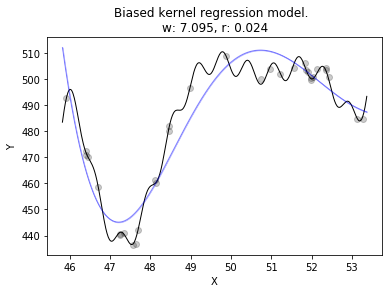

In [4]:
# Define prediction parameters.
sdt1 = 0.001
# Too large width results in a biased model.
w1 = 3.0
kdict = [{'type': 'gaussian', 'width': w1}]
# Set up the prediction routine.
gp = GaussianProcess(kernel_list=kdict, regularization=sdt1,
                     train_fp=std['train'],
                     train_target=train_targets['target'],
                     optimize_hyperparameters=False)
# Do predictions.
under_fit = gp.predict(test_fp=std['test'], uncertainty=True)
# Scale predictions back to the original scale.
under_prediction = np.vstack(under_fit['prediction']) * \
    train_targets['std'] + train_targets['mean']
under_uncertainty = np.vstack(under_fit['uncertainty_with_reg']) * \
    train_targets['std']
# Get average errors.
error = get_error(under_prediction.reshape(-1), afunc(test).reshape(-1))
print('Gaussian linear regression prediction:', error['absolute_average'])
# Get confidence interval on predictions.
upper = under_prediction + under_uncertainty * tstd
lower = under_prediction - under_uncertainty * tstd

# Plot example 1
plt.figure(0)
plt.plot(linex, liney, '-', lw=1, color='black')
plt.plot(train, target, 'o', alpha=0.2, color='black')
plt.plot(test, under_prediction, 'b-', lw=1, alpha=0.4)
plt.fill_between(np.hstack(test), np.hstack(upper), np.hstack(lower),
                interpolate=True, color='blue',
                alpha=0.2)
plt.title('Ex. 1: Biased kernel regression model.  \n' +
          'w: {0:.3f}, r: {1:.3f}'.format(w1 * stdx,
                                          sdt1 * stdy))
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('tight')

Notice the long length scale of the fit and the low predicted uncertainty.

## Model example 2 - over-fitting.

Gaussian kernel regression prediction: 12.397986989873537


(45.44410249578456, 53.74636983584005, 408.447578757366, 597.5315144017272)

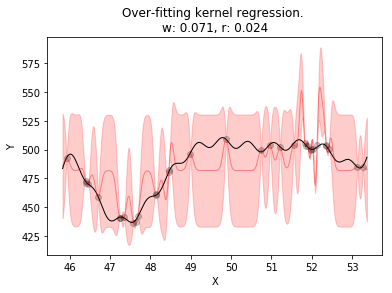

In [5]:
# Define prediction parameters
sdt2 = 0.001
# Too small width lead to over-fitting.
w2 = 0.03
kdict = [{'type': 'gaussian', 'width': w2}]
# Set up the prediction routine.
gp = GaussianProcess(kernel_list=kdict, regularization=sdt2,
                     train_fp=std['train'],
                     train_target=train_targets['target'],
                     optimize_hyperparameters=False)
# Do predictions.
over_fit = gp.predict(test_fp=std['test'], uncertainty=True)
# Scale predictions back to the original scale.
over_prediction = np.vstack(over_fit['prediction']) * \
    train_targets['std'] + train_targets['mean']
over_uncertainty = np.vstack(over_fit['uncertainty_with_reg']) * \
    train_targets['std']
# Get average errors.
error = get_error(over_prediction.reshape(-1), afunc(test).reshape(-1))
print('Gaussian kernel regression prediction:', error['absolute_average'])
# Get confidence interval on predictions.
over_upper = over_prediction + over_uncertainty * tstd
over_lower = over_prediction - over_uncertainty * tstd

# Plot example 2
plt.figure(1)
plt.plot(linex, liney, '-', lw=1, color='black')
plt.plot(train, target, 'o', alpha=0.2, color='black')
plt.plot(test, over_prediction, 'r-', lw=1, alpha=0.4)
plt.fill_between(np.hstack(test), np.hstack(over_upper),
                np.hstack(over_lower), interpolate=True, color='red',
                alpha=0.2)
plt.title('Ex. 2: Over-fitting kernel regression. \n' +
          'w: {0:.3f}, r: {1:.3f}'.format(w2 * stdx,
                                          sdt2 * stdy))
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('tight')

Notice the short lenghtscale of the fit and the high uncertainty. Notice also that the function predicts a constant value (the mean) when it the distance to known data is >> the lengthscale.

## Model example 3 - Optimized Gaussian Process.

Optimized kernel: [{'type': 'gaussian', 'width': [0.44251319468608824]}]
[7.33482991]
Gaussian kernel regression prediction: 2.968499243266082


(45.44410249578456, 53.74636983584005, 426.9740597557922, 520.865699183228)

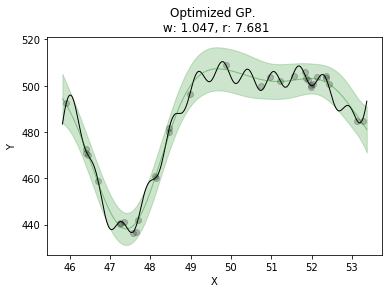

In [6]:
# Set up the prediction routine and optimize hyperparameters.
w3 = 0.1
sdt3 = 0.001
kdict = [{'type': 'gaussian', 'width': [w3]}]

gp = GaussianProcess(kernel_list=kdict, regularization=sdt3,
                     train_fp=std['train'],
                     train_target=train_targets['target'],
                     optimize_hyperparameters=True)
print('Optimized kernel:', gp.kernel_list)
print(-gp.theta_opt['fun'])
# Do the optimized predictions.
optimized = gp.predict(test_fp=std['test'], uncertainty=True)
# Scale predictions back to the original scale.
opt_prediction = np.vstack(optimized['prediction']) * \
    train_targets['std'] + train_targets['mean']
opt_uncertainty = np.vstack(optimized['uncertainty_with_reg']) * \
    train_targets['std']
# Get average errors.
error = get_error(opt_prediction.reshape(-1), afunc(test).reshape(-1))
print('Gaussian kernel regression prediction:', error['absolute_average'])
# Get confidence interval on predictions.
opt_upper = opt_prediction + opt_uncertainty * tstd
opt_lower = opt_prediction - opt_uncertainty * tstd

# Plot eample 3
plt.figure(2)
plt.plot(linex, liney, '-', lw=1, color='black')
plt.plot(train, target, 'o', alpha=0.2, color='black')
plt.plot(test, opt_prediction, 'g-', lw=1, alpha=0.4)
plt.fill_between(np.hstack(test), np.hstack(opt_upper),
                np.hstack(opt_lower), interpolate=True,
                color='green', alpha=0.2)
plt.title('Ex. 3: Optimized GP. \n w: {0:.3f}, r: {1:.3f}'.format(
    gp.kernel_list[0]['width'][0] * stdx,
    np.sqrt(gp.regularization) * stdy))
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('tight')

Here, the lenghtscale is optimized to for the function to fit the data. The uncertainty is high in areas where the data is too sparse.

### Experiment and get intuition.

Now, try playing around with the `train_points` and `noise_magnitude` variables and rerun the models, to get a feel for the behavior of the Gaussian process.

If you are interested in using other Gaussian process codes, such as GPflow, an example has been provided below, for comparison to CatLearn's GP.

## Model example 4 - GPflow.

*** Requires Tensorflow and GPflow ***

GPflow is a Gaussian process code built on top of tensorflow. Therefore it can use certain libraries optimized for GPU's.

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -8.862978
  Number of iterations: 12
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -8.862978
  Number of iterations: 12
  Number of functions evaluations: 18


(45.44410249578456, 53.74636983584005, 429.6378815704347, 517.4843350707014)

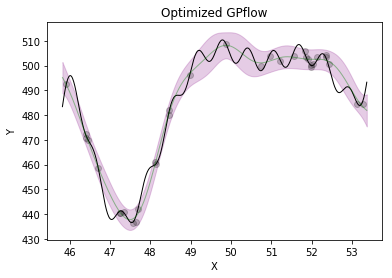

In [7]:
import gpflow

k = gpflow.kernels.RBF(1, lengthscales=0.1)
m = gpflow.models.GPR(np.vstack(std['train']), train_targets['target'],
                      kern=k)
m.likelihood.variance = np.sqrt(0.00003)
gpflow.train.ScipyOptimizer().minimize(m)
mean, var = m.predict_y(std['test'])
# Scale predictions back to the orginal scale.
mean = mean * train_targets['std'] + train_targets['mean']
std_i = (var ** 0.5) * train_targets['std']
opt_upper = mean + std_i * tstd
opt_lower = mean - std_i * tstd
plt.figure(3)
plt.plot(linex, liney, '-', lw=1, color='black')
plt.plot(train, target, 'o', alpha=0.2, color='black')
plt.plot(test, mean, 'g-', lw=1, alpha=0.4)
plt.fill_between(np.hstack(test), np.hstack(opt_upper),
                np.hstack(opt_lower), interpolate=True,
                color='purple', alpha=0.2)
plt.title('Ex. 4: Optimized GPflow')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('tight')

In this example we used GPflow to do a similar Gaussian process as CatLearn's GP.

In [8]:
plt.show()